<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Hitachi_data_engg/Hitachi_Data_Engg_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import data and libraries

In [5]:
!unzip /content/d522aa9cf97211e9.zip

Archive:  /content/d522aa9cf97211e9.zip
   creating: DataSet/
  inflating: DataSet/Train.csv       
 extracting: DataSet/Sample SourceFile Submission.zip  
  inflating: DataSet/sample_submission.csv  
  inflating: DataSet/Test.csv        


In [0]:
from pathlib import Path
import pandas as pd

In [0]:
DATA_PATH = Path('/content/DataSet')

In [8]:
train_data = pd.read_csv(DATA_PATH/'Train.csv', index_col=[0])
train_data.head()

,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,mean_halt_times_source,country_code_destination,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,current_day,is_weekend
id_code,,,,,,,,,,,,,,,,,,
isfywypmkqqhyft,2016-07-27,08:05:51 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
mqsfxyvuqpbwomk,2016-07-27,08:06:11 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
alspwwtbdvqsgby,2016-07-27,08:08:57 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
szitxhhqduyrqpg,2016-07-27,08:09:08 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
krisdqzczivvwcp,2016-07-27,08:11:01 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False


### Look at the data

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1284 entries, isfywypmkqqhyft to hfhwirltuffenfr
Data columns (total 18 columns):
current_date                   1284 non-null object
current_time                   1284 non-null object
source_name                    1284 non-null object
destination_name               1284 non-null object
train_name                     1284 non-null object
target                         1284 non-null object
country_code_source            1283 non-null object
longitude_source               1283 non-null float64
latitude_source                1283 non-null float64
mean_halt_times_source         1283 non-null float64
country_code_destination       1251 non-null object
longitude_destination          1251 non-null float64
latitude_destination           1251 non-null float64
mean_halt_times_destination    1251 non-null float64
current_year                   1284 non-null int64
current_week                   1284 non-null int64
current_day                    1284 n

### Missing data info

In [10]:
train_data.isna().sum()

current_date                    0
current_time                    0
source_name                     0
destination_name                0
train_name                      0
target                          0
country_code_source             1
longitude_source                1
latitude_source                 1
mean_halt_times_source          1
country_code_destination       33
longitude_destination          33
latitude_destination           33
mean_halt_times_destination    33
current_year                    0
current_week                    0
current_day                     0
is_weekend                      0
dtype: int64

In [11]:
columns_with_missing_vals = list((train_data.isna().sum()[lambda x: x>0].index))
columns_with_missing_vals

['country_code_source',
 'longitude_source',
 'latitude_source',
 'mean_halt_times_source',
 'country_code_destination',
 'longitude_destination',
 'latitude_destination',
 'mean_halt_times_destination']

### Explore columns with missing variables

#### Country Code

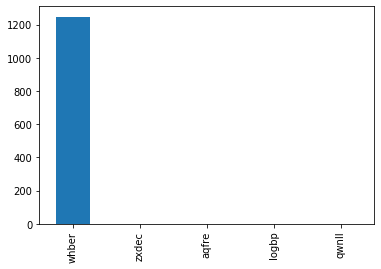

In [12]:
train_data.country_code_destination.value_counts().plot.bar()

In [13]:
train_data.country_code_destination.value_counts()

whber    1247
zxdec       1
aqfre       1
logbp       1
qwnll       1
Name: country_code_destination, dtype: int64

### Plotting the Railway stations

In [14]:
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# Just for legend in the map
le = LabelEncoder()
train_data['target_enc'] = le.fit_transform(train_data['target'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'high': 0, 'low': 1, 'medium': 2}

In [0]:
high_data = train_data[train_data['target_enc'] == 0]
low_data = train_data[train_data['target_enc'] == 1]
med_data = train_data[train_data['target_enc'] == 2]

In [0]:
df_data = []
for df, l, c in zip([high_data, low_data, med_data], ["high", "low", "med"], ['red', 'blue', 'green']):
    df_data.append(go.Scattergeo(
        lon = df['longitude_source'],
        lat = df['latitude_destination'],
        mode = 'markers',
        marker_color = c,
        name=l
        ))

In [17]:
fig = go.Figure(data=df_data)

fig.update_layout(
        title = 'Most trafficked Railway stations',
        geo = dict(
            scope='europe',
            showland=True
        )
    )
fig.show()

### Look at rows with missing data

In [0]:
null_df = train_data[train_data.isnull()]

In [19]:
null_df.shape, train_data.shape

((1284, 19), (1284, 19))

In [21]:
train_data.dropna(how='all').shape

(1284, 19)

This means that there no rows with all na values, The map made with coordinates makes it clear that the data is about railway stations across Belgium,Netherlands, France and the UK(maybe the City of London), there are stations data without coordinates which can be filled with data if only the names of stations were known which is not the case here.

### Data preprocessing

In [0]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder

#### Missing values

As discussed before the missing data can be filled if we knew the names of the railway stations, especially the columns with **latitude**, **longitude** and **country codes**. So any imputation on other columns is useless, so let's drop the rows.

In [0]:
train_data.dropna(how='any', inplace=True)

#### Scaling and encoding data

In [0]:
# These need to be label encoded or one hot encoded
# columns with date time
# .filter(like=['current_date', 'current_time', 'country_code_source', 'country_code_destination'], axis=1)
object_col_df = train_data.select_dtypes(include=['object']).copy()

Peculiar columns include `current_date`, `current_time` which are datetime columns and they are represented as features in other columns eg. `current_year`, `current_week` so they can be safely removed from the dataset.

In [25]:
print(f"""One hot encoded Columns that will be created for some data columns
Number of trains: {len(object_col_df.train_name.unique())}
Number of stations: {pd.np.unique(object_col_df[['source_name', 'destination_name']].values.ravel()).shape[0]}
Number of countries: {pd.np.unique(object_col_df[['country_code_source', 'country_code_destination']].values.ravel()).shape[0]}""")

One hot encoded Columns that will be created for some data columns
Number of trains: 558
Number of stations: 252
Number of countries: 6


In [0]:
target = object_col_df['target']

In [27]:
object_col_df.head()

,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,country_code_destination,current_day
id_code,,,,,,,,,
mgtoldpcbopaoba,2016-07-27,11:41:46 PM,station$130,station$214,ICWVYA,high,whber,whber,Wednesday
hbvekntxnxearzq,2016-07-28,12:04:25 AM,station$248,station$248,ICZVXY,low,whber,whber,Thursday
rfwvjolvzoekxsq,2016-07-28,12:18:09 AM,station$248,station$147,ICZVXY,low,whber,whber,Thursday
jcbfhwsqzpcifpe,2016-07-28,12:38:28 AM,station$177,station$130,ICXUYS,high,whber,whber,Thursday
qfnccvisvjzlkxg,2016-07-28,08:50:27 AM,station$544,station$147,ICZVAT,medium,whber,whber,Thursday


Form `datetime` column from the `current_date` and `current_time` and remove the same

In [0]:
object_col_df.loc[:, 'datetime'] = pd.to_datetime(object_col_df.loc[:, 'current_date']+ ' ' + object_col_df.loc[:, 'current_time'])
object_col_df.drop(columns=['current_date', 'current_time', 'current_day'], inplace=True)

In [29]:
object_col_df.head()

,source_name,destination_name,train_name,target,country_code_source,country_code_destination,datetime
id_code,,,,,,,
mgtoldpcbopaoba,station$130,station$214,ICWVYA,high,whber,whber,2016-07-27 23:41:46
hbvekntxnxearzq,station$248,station$248,ICZVXY,low,whber,whber,2016-07-28 00:04:25
rfwvjolvzoekxsq,station$248,station$147,ICZVXY,low,whber,whber,2016-07-28 00:18:09
jcbfhwsqzpcifpe,station$177,station$130,ICXUYS,high,whber,whber,2016-07-28 00:38:28
qfnccvisvjzlkxg,station$544,station$147,ICZVAT,medium,whber,whber,2016-07-28 08:50:27


Get the date and time  specific features from `datetime` column

In [0]:
import math
object_col_df['DT_M'] = object_col_df['datetime'].dt.month.astype(pd.np.int8)
object_col_df['DT_W'] = object_col_df['datetime'].dt.weekofyear.astype(pd.np.int8)
object_col_df['DT_D'] = object_col_df['datetime'].dt.dayofyear.astype(pd.np.int16)

object_col_df['DT_hour'] = object_col_df['datetime'].dt.hour.astype(pd.np.int8)
object_col_df['DT_day_week'] = object_col_df['datetime'].dt.dayofweek.astype(pd.np.int8)
object_col_df['DT_day_month'] = object_col_df['datetime'].dt.day.astype(pd.np.int8)
object_col_df['DT_week_month'] = object_col_df['datetime'].dt.day/7
object_col_df['DT_week_month'] = object_col_df['DT_week_month'].apply(lambda x: math.ceil(x)).astype(pd.np.int8)

In [0]:
object_col_df.drop(columns=['datetime', 'target'], inplace=True)

Filter again

In [0]:
date_feat = object_col_df.select_dtypes(exclude=['object']).copy()

In [0]:
object_col_df = object_col_df.select_dtypes(exclude=[pd.np.int8, pd.np.int16]).copy()

In [34]:
object_col_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, mgtoldpcbopaoba to hfhwirltuffenfr
Data columns (total 5 columns):
source_name                 1250 non-null object
destination_name            1250 non-null object
train_name                  1250 non-null object
country_code_source         1250 non-null object
country_code_destination    1250 non-null object
dtypes: object(5)
memory usage: 58.6+ KB


Join date features with original dataframes

In [0]:
train_data = train_data.join(date_feat, how='outer')

Let's prep the data now.

In [0]:
ohe = OneHotEncoder(handle_unknown='error', drop='first')

###### Before

In [38]:
object_col_df.shape

(1250, 5)

###### After

In [0]:
ohe_arr = ohe.fit_transform(X=object_col_df)

In [52]:
ohe_arr.shape

(1250, 964)

As expected one hot encoding made too many columns so a **PCA** may be required.

##### Target Encoding

In [0]:
le = LabelEncoder()

In [57]:
target_enc = le.fit_transform(target)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'high': 0, 'low': 1, 'medium': 2}

#### Filtering Scalable data

We have excluded the `date` features created above because they would lose meaning if they are scaled. we will also **exclude the coordinate columns** because we have the `source` and `destination` stations names, since there can only **one pair of coordinates** representing a station, we could confirm by checking the unique count of the respective columns.

In [0]:
# These need to be scaled
num_col_df = train_data.select_dtypes(include=['int', 'float']).copy()

In [0]:
assert len(num_col_df['latitude_source'].unique()) == len(train_data['source_name'].unique())

##### Scaling

In [0]:
num_col_df = num_col_df.filter(like="mean")

In [0]:
scaler = RobustScaler()

###### Before

In [47]:
num_col_df.describe()

,mean_halt_times_source,mean_halt_times_destination
count,1250.000000,1250.000000
mean,269.617010,272.061979
std,224.705656,234.417394
min,0.000000,0.000000
25%,78.488439,71.193642
50%,180.598266,164.419075
75%,421.644509,421.644509
max,686.615607,686.615607


###### After

In [48]:
scaled_num = scaler.fit_transform(num_col_df)
pd.DataFrame(scaled_num, columns=num_col_df.columns).describe()

,mean_halt_times_source,mean_halt_times_destination
count,1250.000000,1250.000000
mean,0.259412,0.307155
std,0.654821,0.668902
min,-0.526286,-0.469164
25%,-0.297561,-0.266016
50%,0.000000,0.000000
75%,0.702439,0.733984
max,1.474598,1.490071


In [49]:
scaled_num.shape

(1250, 2)

### Gather data and save preprocessing objects

In [0]:
unneeded_cols = [
                 'current_date', 'current_time', 'current_year', 'current_week', 'current_day',         # Since we made date features with the datetime column
                 'latitude_destination', 'latitude_source', 'longitude_destination', 'longitude_source' # Since we have the station names
                 ]

In [0]:
# Save everything in a dictionary
encoders_and_data = {
    'target': le,
    'ohe': ohe,
    'ohe_arr': ohe_arr,
    'scaler': scaler,
    'scaled_num': scaled_num,
    'unneeded_cols': unneeded_cols,
    'date_feat': date_feat
}

In [0]:
import joblib

with open('encoders_and_data.joblib', 'wb') as f:
    joblib.dump(encoders_and_data, f)